In [394]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [395]:
from matplotlib.pyplot import imread

In [396]:
from random import shuffle, random
import cv2
from skimage import exposure

In [397]:
data_dir = 'data'

In [398]:
colnames = ['center_img', 'left_img', 'right_img', 'steering_angle', 'throttle', 'break', 'speed']
driving_log_pd = pd.read_csv('%s/driving_log.csv' % data_dir, sep='\t', 
                            names=colnames)
driving_log_pd.loc[:50]

,center_img,left_img,right_img,steering_angle,throttle,break,speed
0,/Users/phillipcchin/work/CarND-Behavioral-Clon...,/Users/phillipcchin/work/CarND-Behavioral-Clon...,/Users/phillipcchin/work/CarND-Behavioral-Clon...,0.000000,0.000000,0,6.427726e-06
1,/Users/phillipcchin/work/CarND-Behavioral-Clon...,/Users/phillipcchin/work/CarND-Behavioral-Clon...,/Users/phillipcchin/work/CarND-Behavioral-Clon...,0.000000,0.000000,0,4.673742e-07
2,/Users/phillipcchin/work/CarND-Behavioral-Clon...,/Users/phillipcchin/work/CarND-Behavioral-Clon...,/Users/phillipcchin/work/CarND-Behavioral-Clon...,0.000000,0.000000,0,2.771526e-06
3,/Users/phillipcchin/work/CarND-Behavioral-Clon...,/Users/phillipcchin/work/CarND-Behavioral-Clon...,/Users/phillipcchin/work/CarND-Behavioral-Clon...,0.000000,0.000000,0,1.514666e-06
4,/Users/phillipcchin/work/CarND-Behavioral-Clon...,/Users/phillipcchin/work/CarND-Behavioral-Clon...,/Users/phillipcchin/work/CarND-Behavioral-Clon...,0.000000,0.000000,0,1.220517e-05
5,/Users/phillipcchin/work/CarND-Behavioral-Clon...,/Users/phillipcchin/work/CarND-Behavioral-Clon...,/Users/phillipcchin/work/CarND-Behavioral-Clon...,0.000000,0.000000,0,2.032721e-06
6,/Users/phillipcchin/work/CarND-Behavioral-Clon...,/Users/phillipcchin/work/CarND-Behavioral-Clon...,/Users/phillipcchin/work/CarND-Behavioral-Clon...,0.000000,0.000000,0,1.386039e-06
7,/Users/phillipcchin/work/CarND-Behavioral-Clon...,/Users/phillipcchin/work/CarND-Behavioral-Clon...,/Users/phillipcchin/work/CarND-Behavioral-Clon...,0.000000,0.000000,0,2.376857e-06
8,/Users/phillipcchin/work/CarND-Behavioral-Clon...,/Users/phillipcchin/work/CarND-Behavioral-Clon...,/Users/phillipcchin/work/CarND-Behavioral-Clon...,0.000000,0.000000,0,2.907404e-06
9,/Users/phillipcchin/work/CarND-Behavioral-Clon...,/Users/phillipcchin/work/CarND-Behavioral-Clon...,/Users/phillipcchin/work/CarND-Behavioral-Clon...,0.000000,0.000000,0,3.305049e-06


In [399]:
def parse_file_name(full_path):
    if '/' in full_path:
        return full_path.split('/')[-1]
    else:
        return full_path

In [400]:
for colname in ['center_img', 'left_img', 'right_img']:
    driving_log_pd[colname] = [parse_file_name(x) for x in driving_log_pd[colname].tolist()]

driving_log_pd.head()

,center_img,left_img,right_img,steering_angle,throttle,break,speed
0,center_2018_01_21_10_24_25_576.jpg,left_2018_01_21_10_24_25_576.jpg,right_2018_01_21_10_24_25_576.jpg,0.0,0.0,0,6.427726e-06
1,center_2018_01_21_10_24_25_666.jpg,left_2018_01_21_10_24_25_666.jpg,right_2018_01_21_10_24_25_666.jpg,0.0,0.0,0,4.673742e-07
2,center_2018_01_21_10_24_25_765.jpg,left_2018_01_21_10_24_25_765.jpg,right_2018_01_21_10_24_25_765.jpg,0.0,0.0,0,2.771526e-06
3,center_2018_01_21_10_24_25_847.jpg,left_2018_01_21_10_24_25_847.jpg,right_2018_01_21_10_24_25_847.jpg,0.0,0.0,0,1.514666e-06
4,center_2018_01_21_10_24_25_947.jpg,left_2018_01_21_10_24_25_947.jpg,right_2018_01_21_10_24_25_947.jpg,0.0,0.0,0,1.220517e-05


In [401]:
def display_images(X, start_idx=0, end_idx=None, 
                       columns = 5, use_gray=False, apply_fnc=None):
    if end_idx is None:
        end_idx = X.shape[0]
        
    if apply_fnc is None:
        apply_fnc = lambda image: image
        
    plt.figure(figsize=(32,18))

    num_of_images = end_idx - start_idx
    rows = num_of_images / columns + 1
    
    for i in range(start_idx, end_idx):
        image = X[i]
        
        _i = i % num_of_images
        plt.subplot(rows, columns, _i + 1)
        
        if use_gray:
            plt.imshow(apply_fnc(image), cmap="gray")
        else:
            plt.imshow(apply_fnc(image)) 
            
    plt.tight_layout()
            
    plt.show()

In [402]:
img_dir = '%s/IMG' % data_dir

In [403]:
def read_imgs(img_dir, file_names):
    img_arr = []
    
    for file_name in file_names:
        img = imread('%s/%s' % (img_dir, file_name))
        img_arr.append(img)
        
    return np.stack(img_arr)

In [404]:
sample_imgs = read_imgs(img_dir, driving_log_pd['center_img'].tolist()[:10])
sample_imgs.shape

(10, 160, 320, 3)

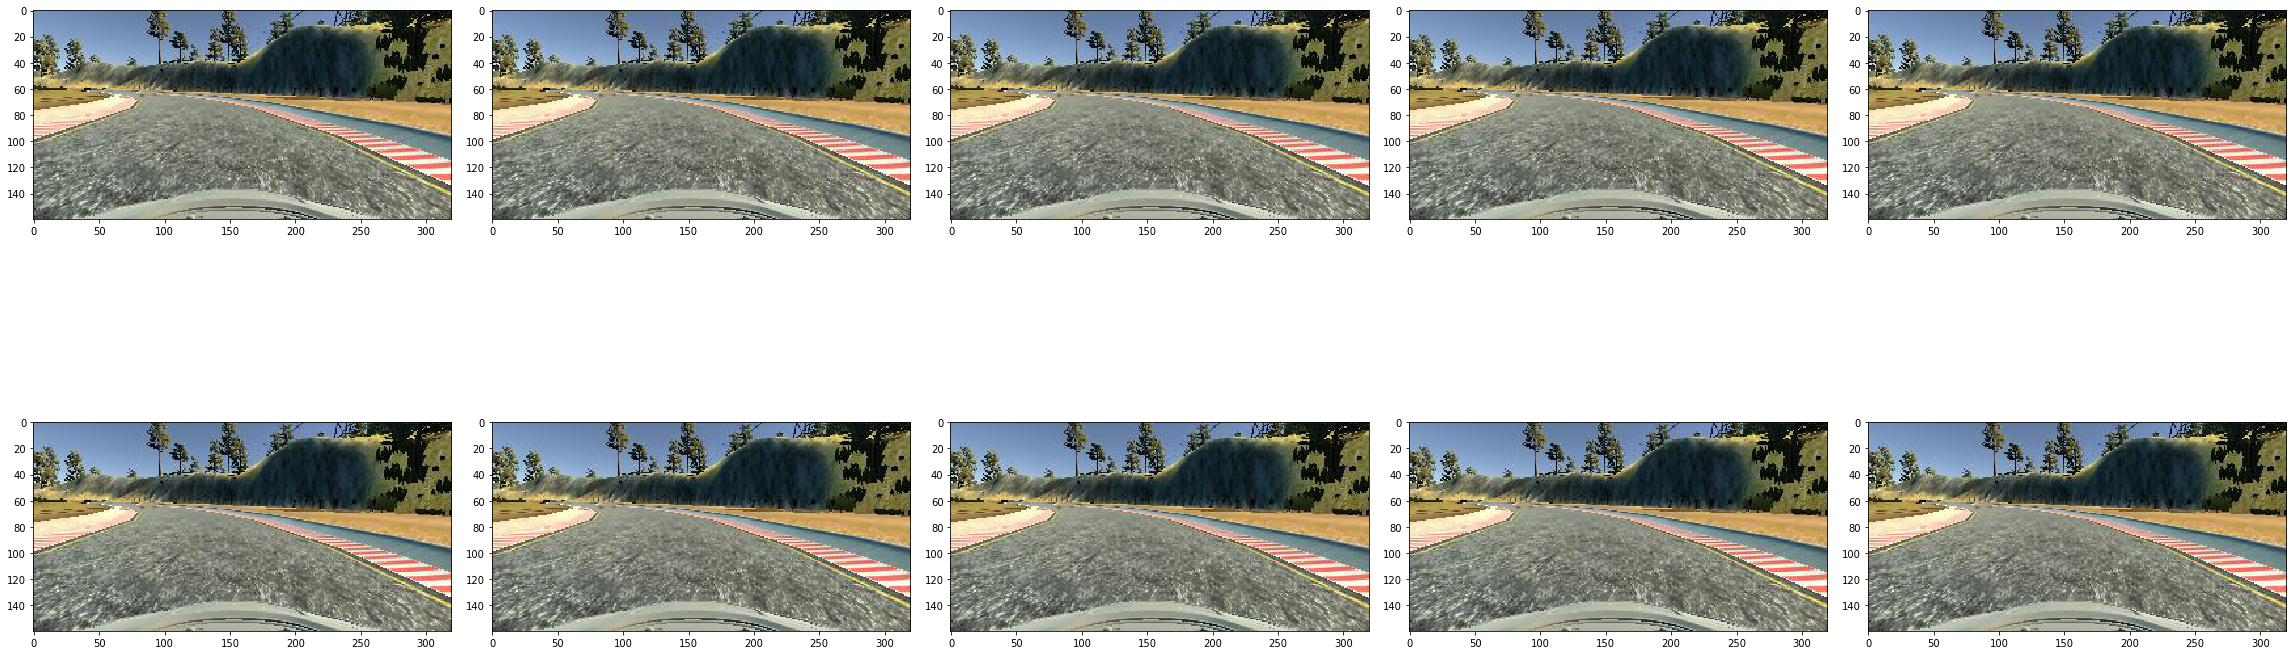

In [405]:
display_images(sample_imgs, columns=5)

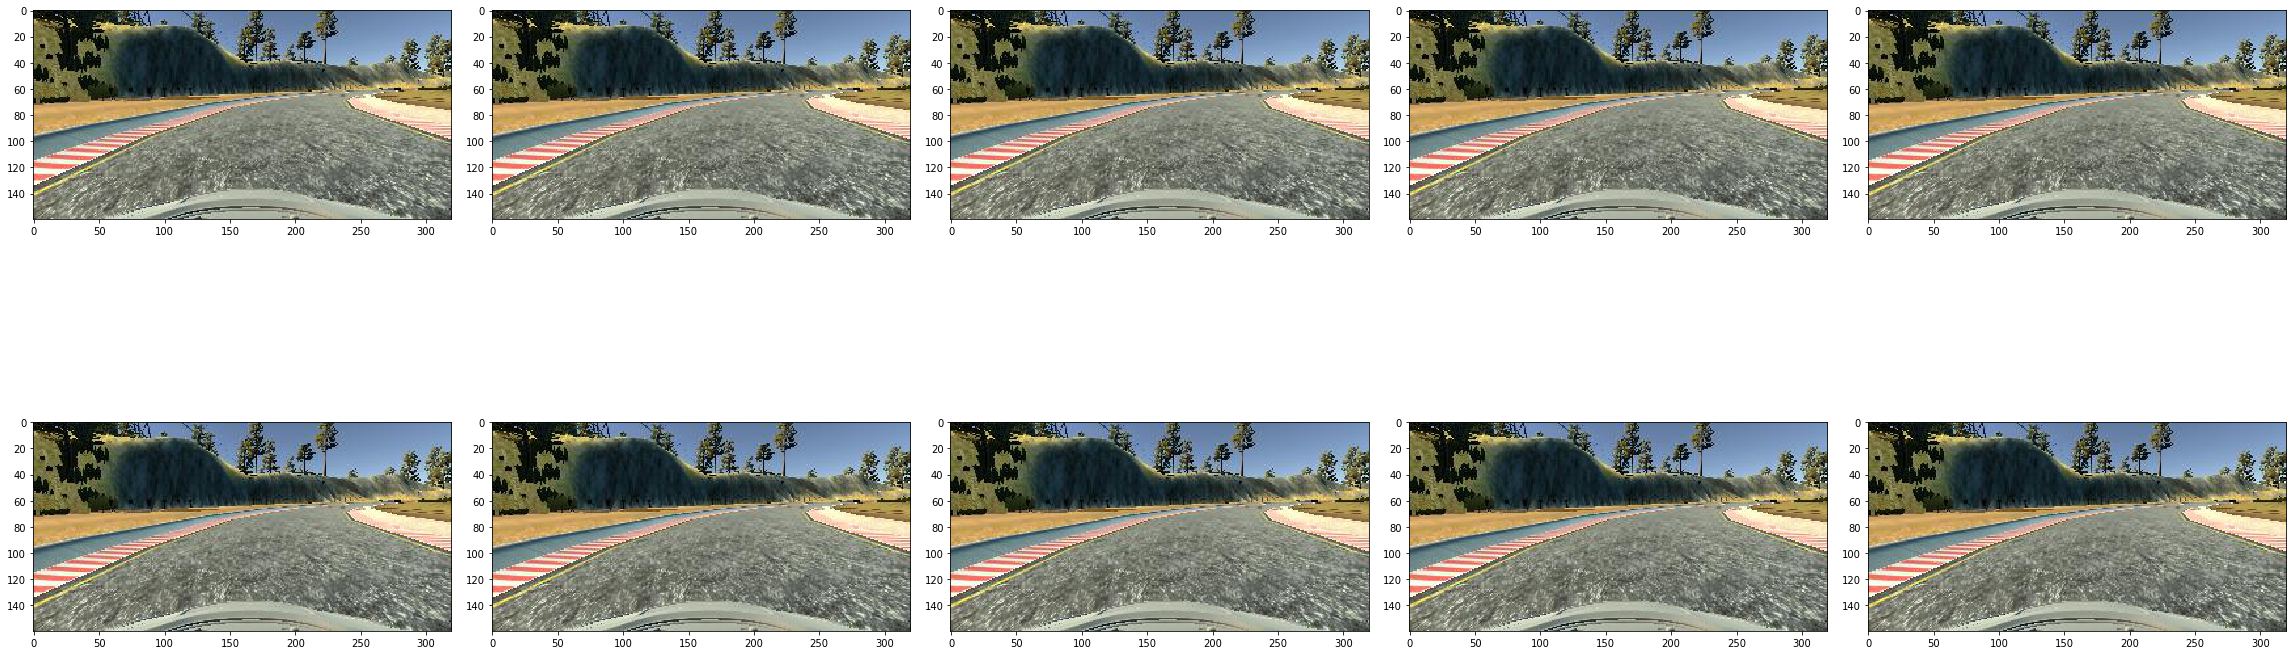

In [406]:
display_images(sample_imgs, columns=5, apply_fnc=np.fliplr)

In [407]:
def apply_histogram_equalization(image):
    gray_image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    equalized_image = exposure.equalize_adapthist(gray_image)
    
    return (255.0*equalized_image).astype(np.uint8)

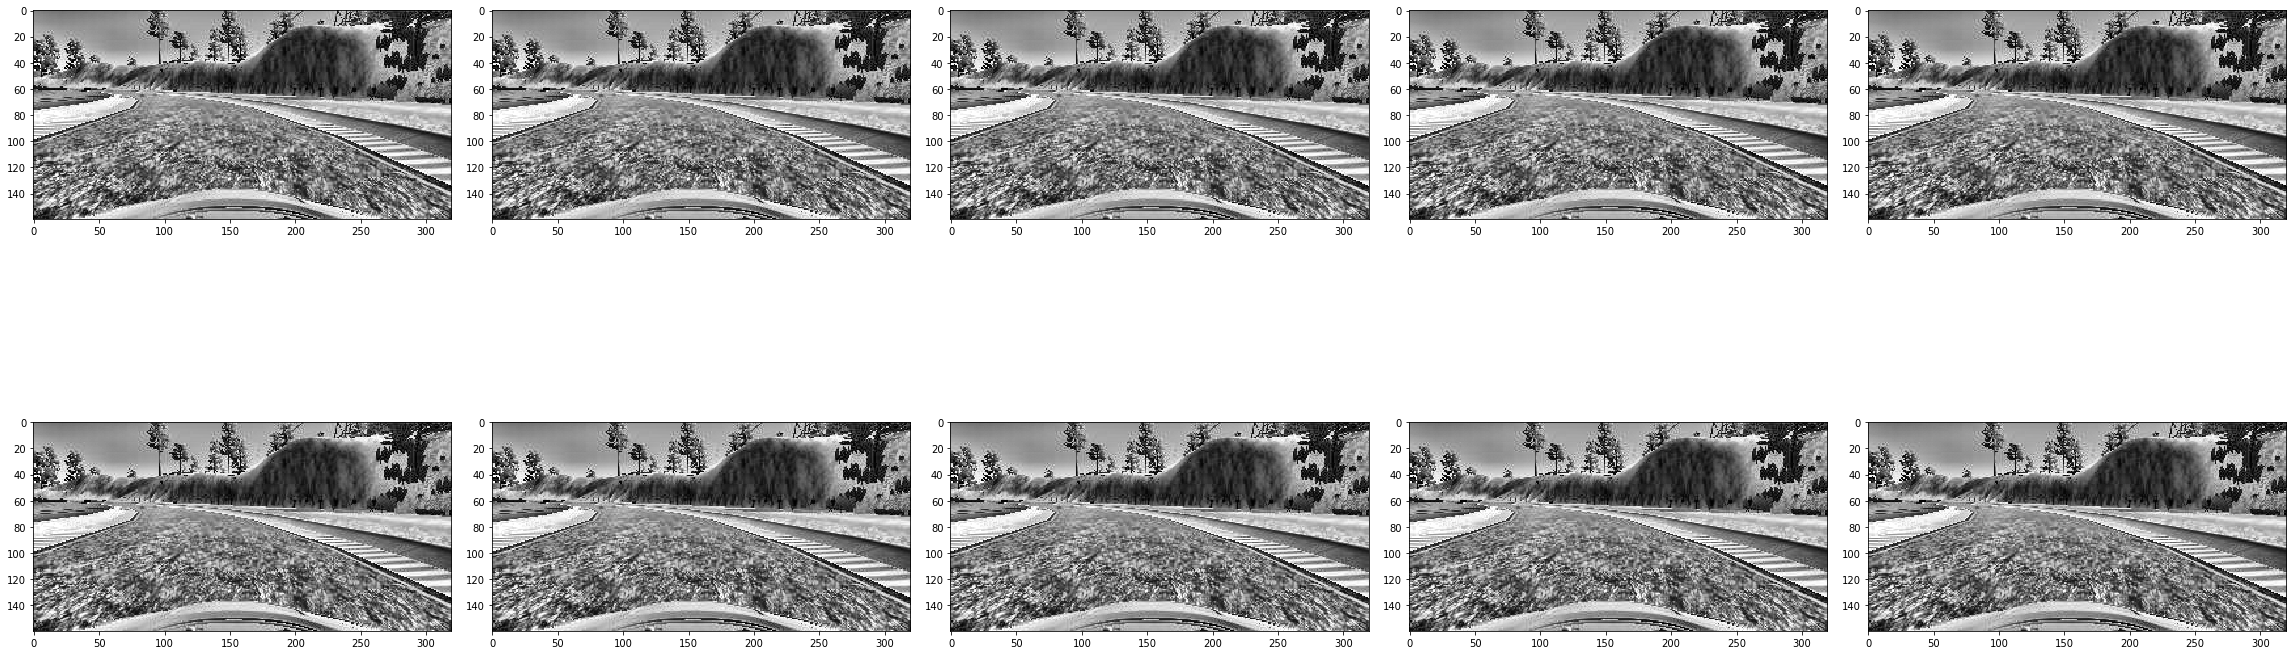

In [408]:
display_images(sample_imgs, columns=5, use_gray=True,
               apply_fnc=apply_histogram_equalization)

## Steering Angles

In [409]:
steering_angles = driving_log_pd['steering_angle'].tolist()

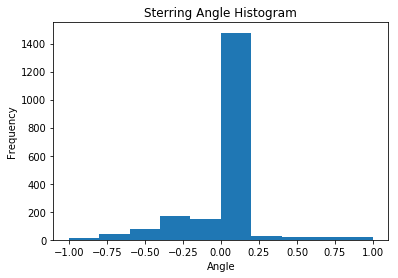

# of bins: 11


In [410]:
n, bins, patches = plt.hist(steering_angles)
plt.title("Sterring Angle Histogram")
plt.xlabel("Angle")
plt.ylabel("Frequency")
plt.show()

print("# of bins: %d" % len(bins))

In [411]:
min(steering_angles), max(steering_angles)

(-1.0, 1.0)

In [412]:
print('minimum frequency: %d' % np.histogram(steering_angles, bins)[0].min())

minimum frequency: 12


## Data

In [413]:
img_steering_pd = driving_log_pd[['center_img', 'steering_angle']]

In [414]:
img_steering_pd['steering_angle'].min(), img_steering_pd['steering_angle'].max()

(-1.0, 1.0)

In [415]:
steering_mean, steering_std = img_steering_pd['steering_angle'].mean(), img_steering_pd['steering_angle'].std()

In [416]:
lower_bound = steering_mean - 2.0*steering_std
upper_bound = steering_mean + 2.0*steering_std
lower_bound, upper_bound

(-0.46755348669480512, 0.38066691091361704)

In [417]:
len(img_steering_pd.index)

2020

In [418]:
filtered_img_steering_pd = img_steering_pd[(img_steering_pd['steering_angle'] >= lower_bound) &
                                           (img_steering_pd['steering_angle'] <= upper_bound)]
filtered_img_steering_pd = filtered_img_steering_pd.reindex()
filtered_img_steering_pd.head()

,center_img,steering_angle
0,center_2018_01_21_10_24_25_576.jpg,0.0
1,center_2018_01_21_10_24_25_666.jpg,0.0
2,center_2018_01_21_10_24_25_765.jpg,0.0
3,center_2018_01_21_10_24_25_847.jpg,0.0
4,center_2018_01_21_10_24_25_947.jpg,0.0


In [419]:
filtered_img_steering_pd.index = list(range(len(filtered_img_steering_pd.index)))

In [458]:
def split_train_test(img_steering_pd, train_perc=0.7, val_perc=0.2):
    idx_len = len(img_steering_pd.index)
    idxs = list(range(idx_len))
    shuffle(idxs)
    
    idx1 = int(idx_len*train_perc)
    idx2 = idx1 + int(idx_len*val_perc)
    
    train_pd = img_steering_pd.loc[idxs[:idx1]]
    val_pd = img_steering_pd.loc[idxs[idx1:idx2]]
    test_pd = img_steering_pd.loc[idxs[idx2:]]
    
    return train_pd, val_pd, test_pd

In [481]:
train_pd, val_pd, test_pd = split_train_test(img_steering_pd)
#train_pd, val_pd, test_pd = split_train_test(filtered_img_steering_pd)
print(len(train_pd.index), len(val_pd.index), len(test_pd.index))

1414 404 202


In [482]:
#_train_pd = train_pd.iloc[:int(0.3*len(train_pd.index))]
_train_pd = train_pd
_val_pd = val_pd
_test_pd = test_pd

In [483]:
X_train = read_imgs(img_dir, _train_pd['center_img'].tolist())
y_train = np.array(_train_pd['steering_angle'])
X_val = read_imgs(img_dir, _val_pd['center_img'].tolist())
y_val = np.array(_val_pd['steering_angle'])
X_test = read_imgs(img_dir, _test_pd['center_img'].tolist())
y_test = np.array(_test_pd['steering_angle'])

In [484]:
X_train.shape

(1414, 160, 320, 3)

## Model

In [485]:
from keras.models import Sequential
from keras.layers import Activation, Flatten, Dense, Lambda, Conv2D, MaxPooling2D, Dropout
from keras.optimizers import Adam

In [486]:
from keras import backend as K

In [487]:
import keras
keras.__version__

'1.2.1'

In [488]:
import tensorflow as tf
tf.__version__

'0.12.1'

In [489]:
def apply_histogram_equalization_to_images(images, n):
    image_arr = []
    
    for i in range(n):
        image_arr.append(apply_histogram_equalization(images[i]))
        
    return np.stack(image_arr)

In [490]:
batch_size=32
p = 0.5

In [491]:
model = Sequential()
model.add(Lambda(lambda x: K.tf.image.rgb_to_grayscale(x), input_shape=(160,320,3)))
model.add(Lambda(lambda x: x / 255.0 - 0.5))
#model.add(Lambda(lambda x: x / 255.0 - 0.5, input_shape=(160,320,3)))

# block 1
model.add(Conv2D(8, nb_row=3, nb_col=3, subsample=(1, 1), border_mode='same', 
                 activation='relu'))
model.add(Conv2D(8, nb_row=3, nb_col=3, subsample=(1, 1), border_mode='same', 
                 activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2,2), border_mode='same'))
#model.add(Dropout(p))

# block 2
model.add(Conv2D(16, nb_row=3, nb_col=3, subsample=(1, 1), border_mode='same', 
                 activation='relu'))
model.add(Conv2D(16, nb_row=3, nb_col=3, subsample=(1, 1), border_mode='same', 
                 activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2,2), border_mode='same'))
#model.add(Dropout(p))

# block 3
model.add(Conv2D(32, nb_row=3, nb_col=3, subsample=(1, 1), border_mode='same', 
                 activation='relu'))
model.add(Conv2D(32, nb_row=3, nb_col=3, subsample=(1, 1), border_mode='same', 
                 activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2,2), border_mode='same'))
#model.add(Dropout(p))
          
model.add(Flatten())          
 
model.add(Dense(128, activation=None))
model.add(Dropout(p))
model.add(Activation('relu'))
model.add(Dense(1))

In [492]:
from sklearn.utils import shuffle as shuffle_X_y

In [493]:
def image_gen(X, y, batch_size, flip_perc=0.5):
    X_len = X.shape[0]
    
    while True:
        X, y = shuffle_X_y(X, y)
        
        for i in range(0, X_len, batch_size):
            end_idx = min(i+batch_size, X_len)
            
            curr_X = X[i:end_idx].copy()
            curr_y = y[i:end_idx].copy()
            
            """
            for j in range(curr_X.shape[0]):
                if random() > flip_perc:
                    curr_X[j] = np.fliplr(curr_X[j])
                    curr_y[j] = -1.0 * curr_y[j]
            """
                    
            yield curr_X, curr_y

In [494]:
lr=0.0001
nb_epoch=10

optimizer = Adam(lr=lr)
model.compile(loss='mse', optimizer=optimizer)

train_gen = image_gen(X_train, y_train, batch_size)
model.fit_generator(train_gen, validation_data=(X_val, y_val), 
                    samples_per_epoch=X_train.shape[0],
                    nb_epoch=nb_epoch, nb_worker=1)

Epoch 1/10
1414/1414 [==============================] - 174s - loss: 0.0493 - val_loss: 0.0345

In [495]:
test_loss = model.evaluate(X_test, y_test)
test_loss

202/202 [==============================] - 8s     


0.030375075222241997

In [496]:
model.save('%s/model.h5'%data_dir)